  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1 ] Loss : 0.503807
Epoch 1 ] Accuracy : 88.76%
Epoch 2 ] Loss : 0.272274
Epoch 2 ] Accuracy : 90.43%
Epoch 3 ] Loss : 0.222663
Epoch 3 ] Accuracy : 91.24%
Epoch 4 ] Loss : 0.187307
Epoch 4 ] Accuracy : 91.67%
Epoch 5 ] Loss : 0.156905
Epoch 5 ] Accuracy : 91.81%
Epoch 6 ] Loss : 0.125692
Epoch 6 ] Accuracy : 92.03%
Epoch 7 ] Loss : 0.097970
Epoch 7 ] Accuracy : 92.41%
Epoch 8 ] Loss : 0.073203
Epoch 8 ] Accuracy : 92.73%
Epoch 9 ] Loss : 0.053303
Epoch 9 ] Accuracy : 92.33%
Epoch 10 ] Loss : 0.044208
Epoch 10 ] Accuracy : 92.35%
Epoch 11 ] Loss : 0.035821
Epoch 11 ] Accuracy : 91.96%
Epoch 12 ] Loss : 0.029999
Epoch 12 ] Accuracy : 92.76%
Epoch 13 ] Loss : 0.026709
Epoch 13 ] Accuracy : 92.27%
Epoch 14 ] Loss : 0.026003
Epoch 14 ] Accuracy : 92.39%
Epoch 15 ] Loss : 0.019206
Epoch 15 ] Accuracy : 92.34%
Epoch 16 ] Loss : 0.020094
Epoch 16 ] Accuracy : 92.18%
Epoch 17 ] Loss : 0.019529
Epoch 17 ] Accuracy : 92.49%
Epoch 18 ] Loss : 0.015109
Epoch 18 ] Accuracy : 92.30%
Epoch 19 ]

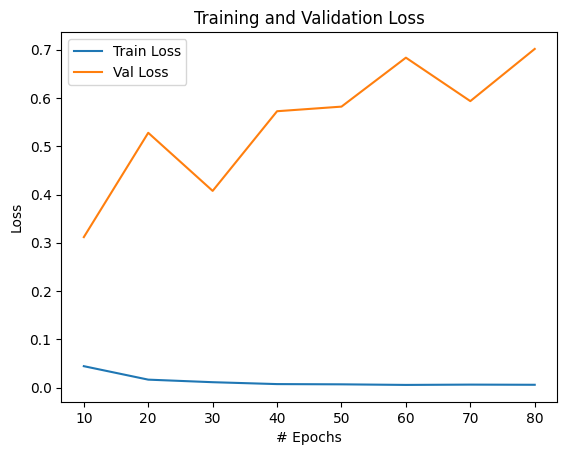

In [54]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms, datasets
from torchvision.utils import save_image
import torch.optim as optim
from pathlib import Path
from tqdm.notebook import tqdm

epoch = 80
learning_rate = 1e-4
load_model = True

DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])

train_set = datasets.FashionMNIST('./datasets/', download=True, train=True, transform=transform)

val_size = 10000
train_size = len(train_set) - val_size
train_set, val_set = random_split(train_set, [train_size, val_size])
test_set = datasets.FashionMNIST('./datasets/', download=True, train=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x
    
model = VGG16().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

train_losses = []
val_losses = []
epochs_list = []

for epochs in tqdm(range(epoch)): #I decided to train the model for 50 epochs
    loss_ep = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores, targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    
    print(f"Epoch {epochs+1} ] Loss : {loss_ep/len(train_loader):.6f}")
    
    if (epochs + 1) in [10, 20, 30, 40, 50, 60, 70, 80]:
        train_losses.append(loss_ep / len(train_loader))
        
        with torch.no_grad():
            val_loss_ep = 0
            for batch_idx, (data, targets) in enumerate(val_loader):
                data = data.to(DEVICE)
                targets = targets.to(DEVICE)
                scores = model(data)
                val_loss = criterion(scores, targets)
                val_loss_ep += val_loss.item()
            val_losses.append(val_loss_ep / len(val_loader))
        
        epochs_list.append(epochs + 1)
        
        # Save the model at the desired epoch
        torch.save(model.state_dict(), f"model_epoch_{epochs+1}.pth")
    
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data, targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(f"Epoch {epochs+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%")
        

dest = Path("figures")
dest.mkdir(parents=True, exist_ok=True)
dest1 = dest / "vgg16_fmnist_wt_diff_batches.png"
plt.plot(epochs_list, train_losses, label='Train Loss')
plt.plot(epochs_list, val_losses, label='Val Loss')
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(dest1)
plt.show()